In [95]:
#Import package
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

##Funcitions 

In [96]:
#------------#
# Function for Visualising Images
def imshow(img):
    plt.axis('off')
    plt.imshow(img, 'gray')
    plt.show()

Original Image


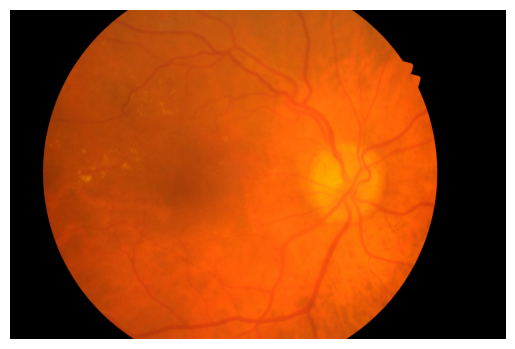

In [97]:
#Input image
img_groundtruths=cv2.imread("data/groundtruths/training/hard exudates/IDRiD_10_EX.tif",cv2.IMREAD_COLOR)
image_path = "data/images/test/"
image_path = "data/images/training/"

images = os.listdir(image_path)
images.sort()
image_id="IDRiD_15.jpg"
img= cv2.imread(image_path + image_id,cv2.IMREAD_COLOR)
print("Original Image")
imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

Conversation into green channel image


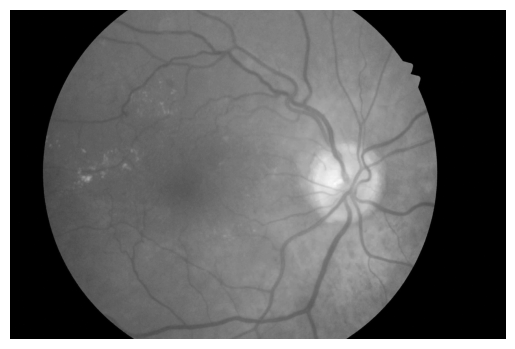

In [98]:
B,img_G,R=cv2.split(img)
imshow(img_G)

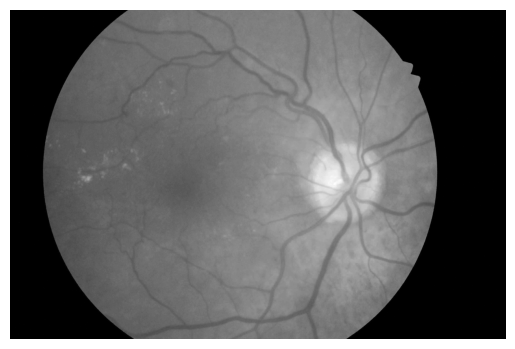

In [99]:
median_fltr= cv2.medianBlur(img_G,5)
imshow(median_fltr)

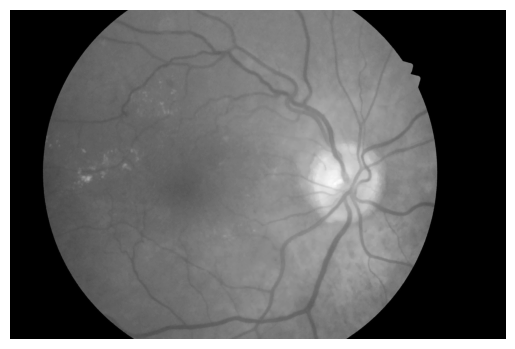

In [100]:
img_nonLocal=cv2.fastNlMeansDenoising(img_G,None,3,3,21)
imshow(img_nonLocal)

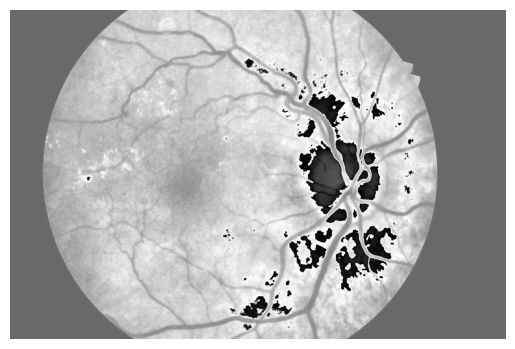

In [101]:
clahe=cv2.createCLAHE(clipLimit=5)
cl12=clahe.apply(img_nonLocal)+100
imshow(cl12)


Closed binary image


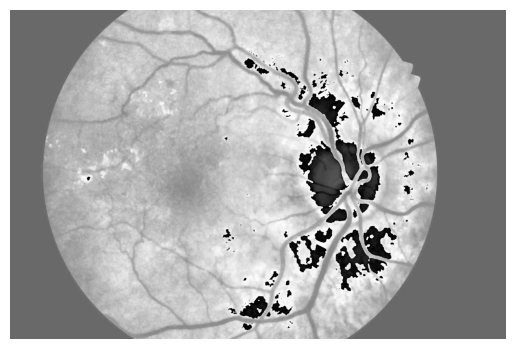

In [102]:
# morphology close 
karnel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
img_bainary_close= cv2.morphologyEx(cl12,cv2.MORPH_OPEN,karnel)
print("Closed binary image")
imshow(img_bainary_close)

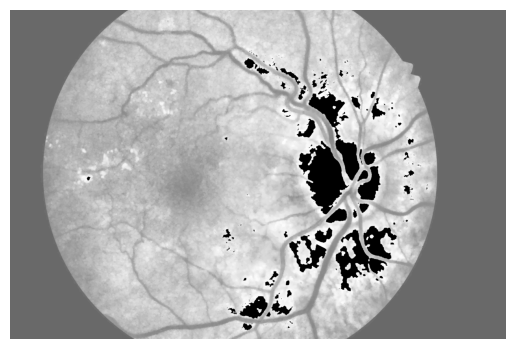

In [110]:
ret, img_labt = cv2.threshold(img_bainary_close,100,255,cv2.THRESH_TOZERO)
imshow(img_labt)

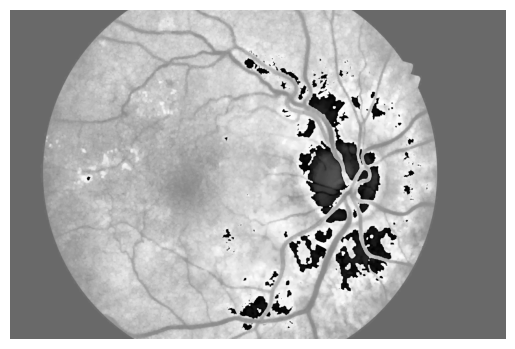

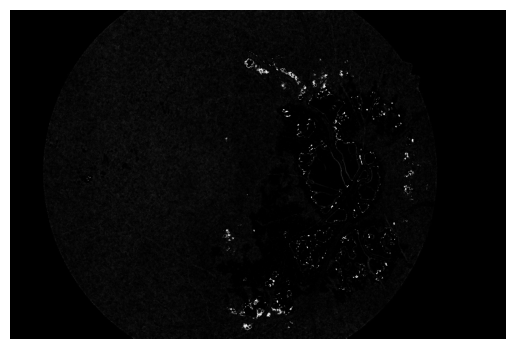

In [112]:
kernel = np.ones((11,11),np.uint8)
tophat_img1=cv2.morphologyEx(cl12,cv2.MORPH_OPEN,kernel)
imshow(tophat_img1)
btm_hat_img=cv2.morphologyEx(cl12,cv2.MORPH_BLACKHAT,kernel)
imshow(btm_hat_img)

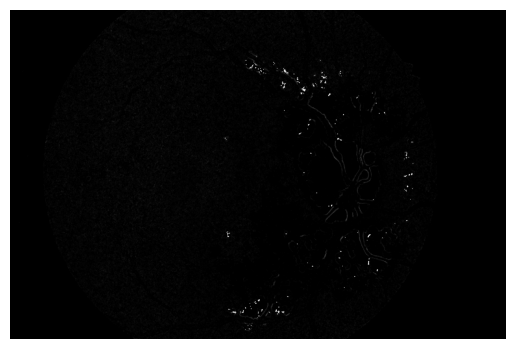

In [105]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(tophat_img1,cv2.MORPH_OPEN,kernel, iterations = 2)
imshow(opening)

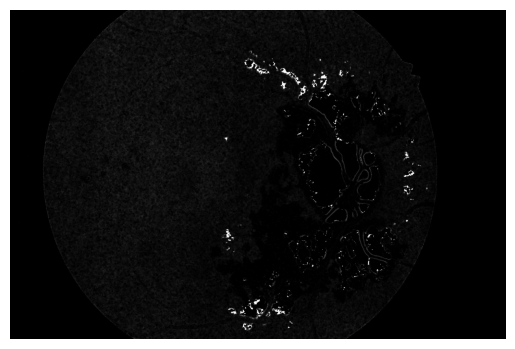

In [106]:
close = cv2.morphologyEx(tophat_img1,cv2.MORPH_CLOSE,kernel, iterations = 2)
imshow(close)

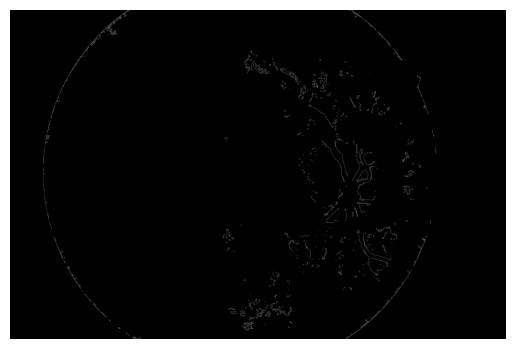

In [107]:
median=cv2.medianBlur(close,3)
median=cv2.Canny(median,20,255)
imshow(median)

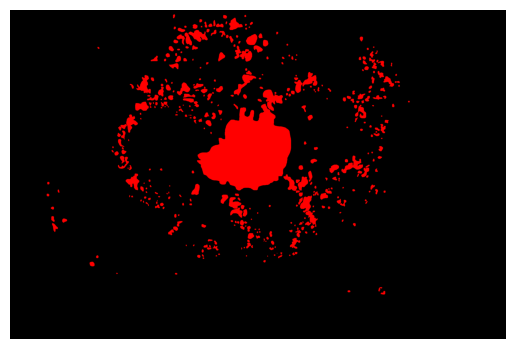

In [108]:
img_groundtruths=cv2.cvtColor(img_groundtruths,cv2.COLOR_BGR2RGB)
imshow(img_groundtruths)